In [ ]:
import os

In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/images_dataset.zip -d /content/drive/MyDrive/images_data

Archive:  /content/drive/MyDrive/images_dataset.zip
replace /content/drive/MyDrive/images_data/_test/airplane/airplane_0582.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/images_data/_test/airplane/airplane_0583.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = "/content/drive/MyDrive/images_data/_train"
test_data_dir = "/content/drive/MyDrive/images_data/_test"

In [ ]:
files = os.listdir(data_dir)
for cls in files:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    image = Image.open(os.path.join(cls_path, images[0]))
    print("Class {} contains {} images of shape {}".format(
        cls, len(images), image.size))
    for f in images:
        if f.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path, f))
            print("removed {}".format(f))

Class airplane contains 619 images of shape (298, 112)
Class car contains 871 images of shape (100, 100)
Class cat contains 797 images of shape (360, 320)
Class dog contains 597 images of shape (477, 493)
Class flower contains 717 images of shape (677, 1012)
Class fruit contains 850 images of shape (100, 100)
Class motorbike contains 670 images of shape (180, 102)
Class person contains 838 images of shape (256, 256)


In [ ]:
class_names = []
for image_class in os.listdir(data_dir):
    class_names.append(image_class)

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [ ]:
from sklearn.utils import shuffle
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2 as cv

Follow the original noteblook the model: [link](https://www.kaggle.com/code/kkhandekar/classify-your-images-cnn-keras)

In [ ]:
def load_data():
    datasets = [data_dir,test_data_dir]
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print(f"Loading {dataset}")
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv.imread(img_path)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, IMAGE_SIZE)

                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return output


In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/images_data/_train


100%|██████████| 838/838 [00:21<00:00, 39.66it/s] 


Loading /content/drive/MyDrive/images_data/_test


100%|██████████| 148/148 [00:04<00:00, 31.17it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
test_images, test_labels = shuffle(test_images, test_labels, random_state=25)

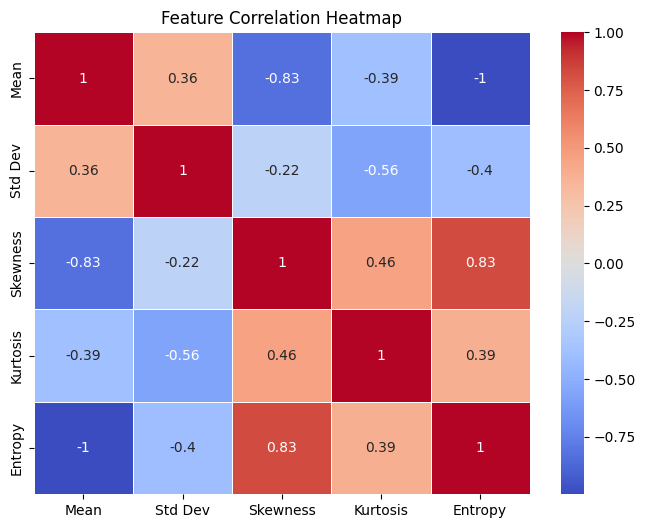

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

def extract_features(images):
    features = []
    for img in images:
        mean_intensity = np.mean(img)
        std_dev = np.std(img)
        skewness = stats.skew(img.flatten())
        kurt = stats.kurtosis(img.flatten())
        entropy = -np.sum(img * np.log2(img + 1e-8))

        features.append([mean_intensity, std_dev, skewness, kurt, entropy])

    return pd.DataFrame(features, columns=["Mean", "Std Dev", "Skewness", "Kurtosis", "Entropy"])

feature_df = extract_features(train_images)

corr_matrix = feature_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Explore Dataset

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 5959
Number of testing examples: 940
Each image is of size: (150, 150)


In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
df = pd.DataFrame({'train': train_counts,
                   'test': test_counts},
                  index=class_names)

In [ ]:
df

,train,test
airplane,619,108
car,871,97
cat,797,88
dog,597,105
flower,717,126
fruit,850,150
motorbike,670,118
person,838,148


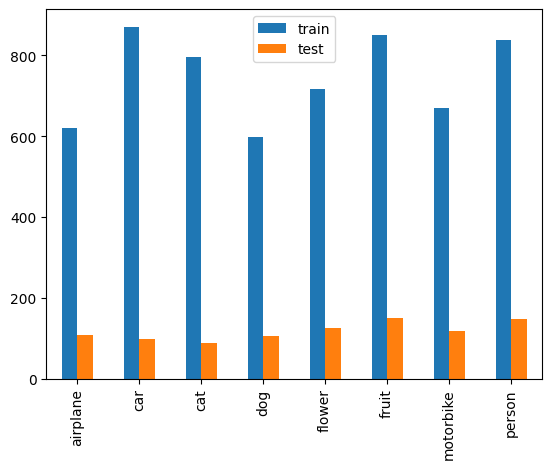

In [ ]:
df.plot.bar()
plt.show()

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
def display(class_names, images, labels, title):
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(title, fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

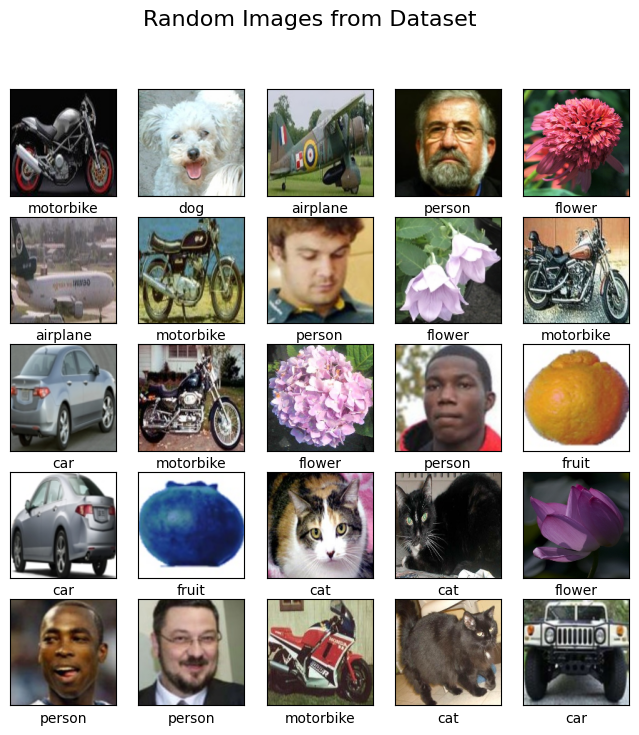

In [ ]:
display(class_names, train_images, train_labels, title="Random Images from Dataset")

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report


In [ ]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(8, activation=tf.nn.softmax))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,319,720 (20.29 MB)

 Trainable params: 5,319,720 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') == 1):
            print(logs.get('val_accuracy'))
            print("\nReached 100% validation accuracy so cancelling training!")
callbacks = myCallback()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=2,
    min_lr=1e-6,
    verbose=2
)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2, callbacks=[callbacks, reduce_lr])

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.3685 - loss: 2.0046 - val_accuracy: 0.7919 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8222 - loss: 0.4908 - val_accuracy: 0.8473 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9033 - loss: 0.2631 - val_accuracy: 0.8792 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9143 - loss: 0.2128 - val_accuracy: 0.8993 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9573 - loss: 0.1294 - val_accuracy: 0.9052 - val_loss: 0.2593 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9763 - loss: 0.0877 - val_accuracy: 0.9060 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9731 - loss: 0.0870 - val_a

In [ ]:
model.save("cnn_model.h5")

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    # ax1.plot(epochs, acc, 'r', label='Training accuracy')
    # ax1.plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    # ax2.plot(epochs, loss, 'r', label='Training Loss')
    # ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

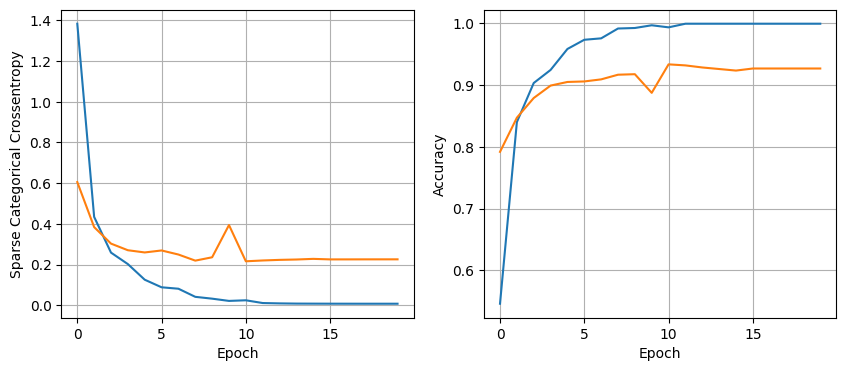

In [ ]:
plot_history(history)

In [ ]:
test_accuracy = model.evaluate(test_images, test_labels)[1]*100

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9405 - loss: 0.2113


In [ ]:
train_accuracy = history.history['accuracy'][-1]

In [ ]:
print("Accuracy of the model is: " , model.evaluate(test_images, test_labels)[1]*100 , "%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9405 - loss: 0.2113
Accuracy of the model is:  93.08510422706604 %


## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis = 1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
print(classification_report(test_labels, predictions, target_names = class_names))

              precision    recall  f1-score   support

    airplane       0.98      0.96      0.97       108
         car       0.98      0.97      0.97        97
         cat       0.68      0.84      0.75        88
         dog       0.81      0.67      0.73       105
      flower       0.97      0.94      0.95       126
       fruit       0.99      1.00      1.00       150
   motorbike       0.99      0.99      0.99       118
      person       0.97      1.00      0.99       148

    accuracy                           0.93       940
   macro avg       0.92      0.92      0.92       940
weighted avg       0.93      0.93      0.93       940



<Axes: >

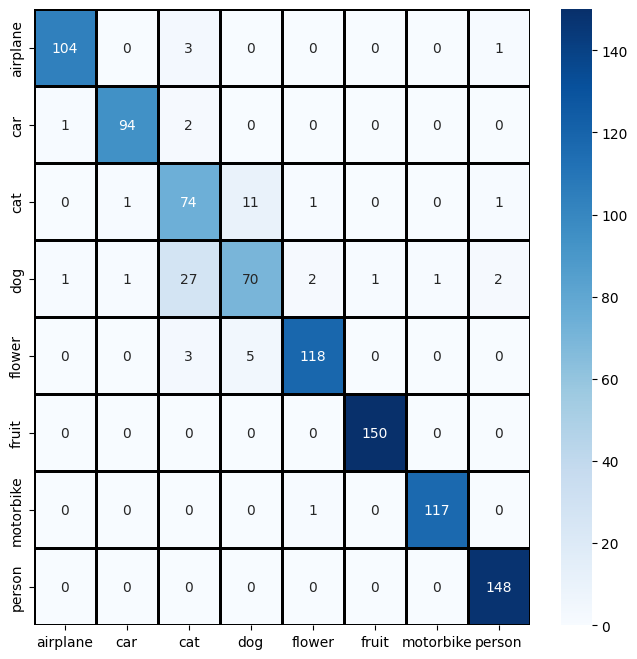

In [ ]:
cm = confusion_matrix(test_labels,predictions)
cm = pd.DataFrame(cm , index = class_names , columns = class_names)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
def check_images(class_names, test_images, test_labels, predictions, title):

    fig = plt.figure(figsize=(12,12))
    fig.suptitle(title, fontsize=16)

    for i in range(25):
        true_class = class_names[test_labels[i]]

        prediction_class = class_names[predictions[i]]

        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        plt.xlabel(f"Actual Class: {true_class}\n Predicted Class: {prediction_class}", fontsize=8)
    plt.show()

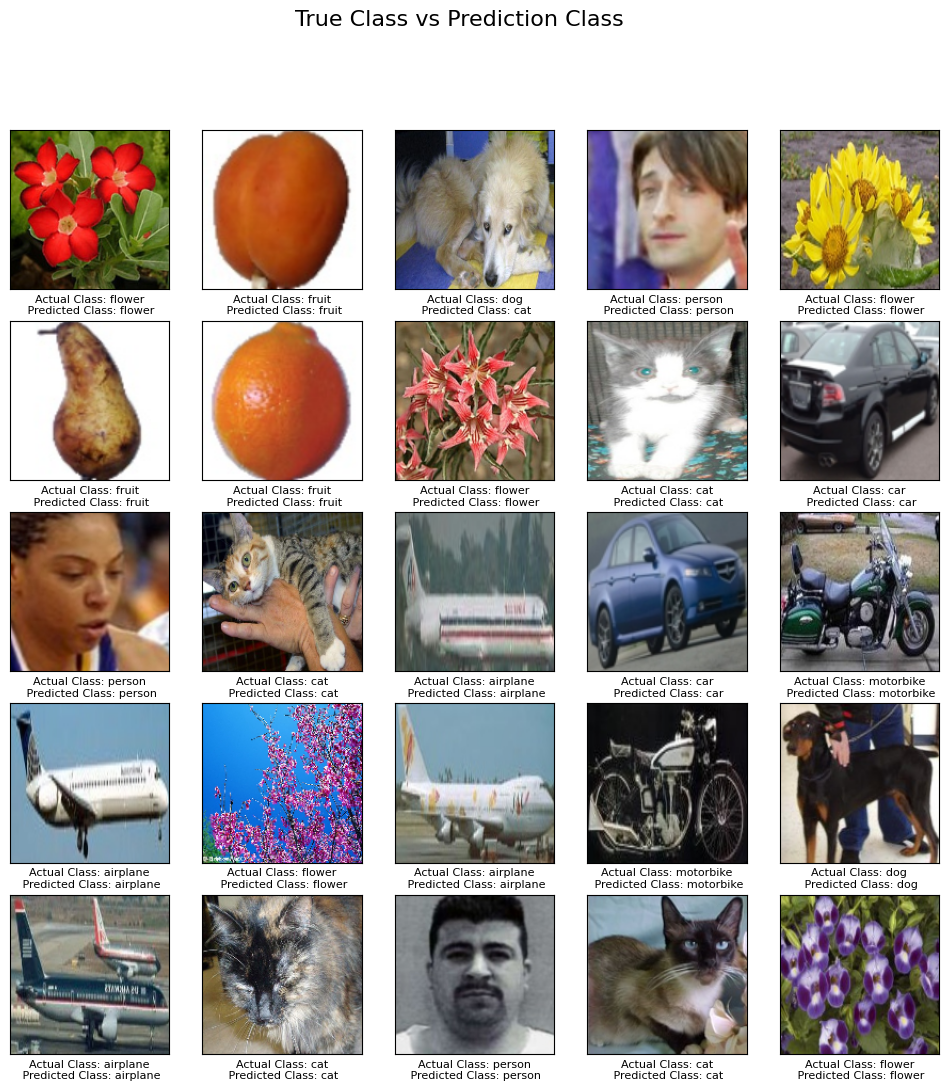

In [ ]:
check_images(class_names, test_images, test_labels, predictions, title="True Class vs Prediction Class")

In [ ]:
from scipy.stats import ttest_ind

def z_test(p1, p2, n1, n2):
    p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return z_score, p_value

train_samples = len(train_images)
test_samples = len(test_images)
z_score, p_value = z_test(train_accuracy, test_accuracy, train_samples, test_samples)
print(f"Z-score: {z_score:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference between train and test accuracy (p < 0.05). Model may be overfitting.")
else:
    print("No significant difference between train and test accuracy.")



Z-score: nan, P-value: nan
No significant difference between train and test accuracy.


<ipython-input-47-5f042ff560f0>:6: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))


In [ ]:
t_stat, t_p_value = ttest_ind(history.history['accuracy'], history.history['val_accuracy']) # Now you can use ttest_ind
print(f"T-test Statistic: {t_stat:.4f}, P-value: {t_p_value:.4f}")

T-test Statistic: 1.9315, P-value: 0.0609


In [ ]:
from scipy.stats import f_oneway

anova_stat, anova_p_value = f_oneway(history.history['accuracy'], history.history['val_accuracy'])
print(f"ANOVA F-statistic: {anova_stat:.4f}, P-value: {anova_p_value:.4f}")

if anova_p_value < 0.05:
    print("Significant differences exist between training and validation accuracy over epochs.")
else:
    print("No significant differences between training and validation accuracy.")

ANOVA F-statistic: 3.7308, P-value: 0.0609
No significant differences between training and validation accuracy.
